In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [2]:
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__)
print(tf.keras.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
2.10.0


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Paths
data_dir = r"C:\Users\Jaero\Desktop\Programming\DP1\Plant_Disease_Prediction\data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Parameters
img_size = (224, 224)   # MobileNetV2 input size
batch_size = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 1050 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 148 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Anthracnose', 'Healthy', 'OtherDisease']


In [5]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess(images, labels):
    images = preprocess_input(images)  # Important for MobileNetV2
    return images, labels

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [6]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2

num_classes = len(class_names)

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # set higher, early stopping will stop when needed
    callbacks=[early_stop]
)

Epoch 1/30
33/33 [==============================] - 19s 178ms/step - loss: 1.2460 - accuracy: 0.3990 - val_loss: 1.0173 - val_accuracy: 0.4867
Epoch 2/30
33/33 [==============================] - 5s 163ms/step - loss: 1.0240 - accuracy: 0.5057 - val_loss: 0.8153 - val_accuracy: 0.6600
Epoch 3/30
33/33 [==============================] - 5s 159ms/step - loss: 0.8256 - accuracy: 0.6095 - val_loss: 0.6761 - val_accuracy: 0.7433
Epoch 4/30
33/33 [==============================] - 5s 162ms/step - loss: 0.7129 - accuracy: 0.6971 - val_loss: 0.5756 - val_accuracy: 0.7867
Epoch 5/30
33/33 [==============================] - 6s 166ms/step - loss: 0.5896 - accuracy: 0.7619 - val_loss: 0.5037 - val_accuracy: 0.8167
Epoch 6/30
33/33 [==============================] - 6s 172ms/step - loss: 0.5463 - accuracy: 0.7838 - val_loss: 0.4436 - val_accuracy: 0.8367
Epoch 7/30
33/33 [==============================] - 6s 177ms/step - loss: 0.4867 - accuracy: 0.8286 - val_loss: 0.3972 - val_accuracy: 0.8633
Epoch

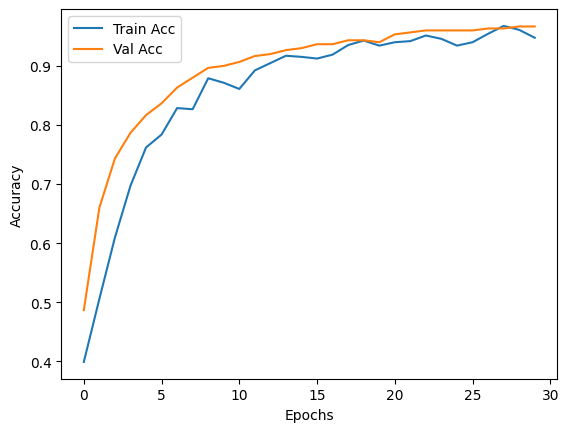

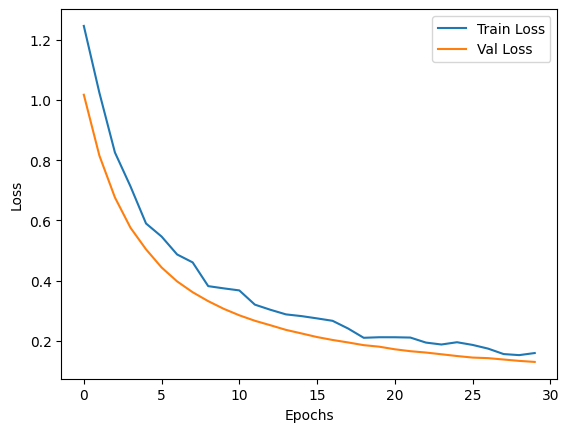

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:


y_true = []
y_pred_classes = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# # Save Keras model
# model.save("mango_mobilenetv2.h5")

# # Convert to TensorFlow Lite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# with open("mango_mobilenetv2.tflite", "wb") as f:
#     f.write(tflite_model)

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

 Anthracnose       1.00      0.96      0.98        50
     Healthy       1.00      1.00      1.00        50
OtherDisease       0.96      1.00      0.98        48

    accuracy                           0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148



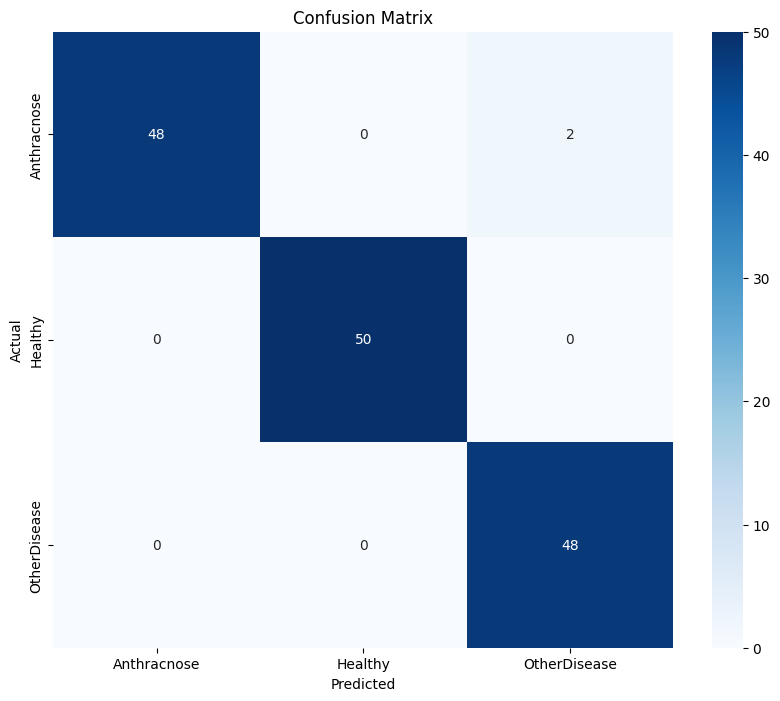

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true and y_pred_classes are already correct
# class_names is your list of class labels

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
for images, labels in test_ds.take(1):
    preds = np.argmax(model.predict(images), axis=1)
    print("Predicted:", preds)
    print("Actual   :", labels.numpy())

1/1 [==============================] - 0s 43ms/step
Predicted: [1 2 2 0 0 0 1 1 1 1 0 0 1 2 2 0 2 2 0 2 1 1 0 0 1 2 2 0 0 2 0 0]
Actual   : [1 2 2 0 0 0 1 1 1 1 0 0 1 0 2 0 2 2 0 2 1 1 0 0 1 2 2 0 0 2 0 0]


In [12]:
print(class_names)
print(model.output_shape)

['Anthracnose', 'Healthy', 'OtherDisease']
(None, 3)


In [13]:
# Old method
y_true_old = np.concatenate([y for x, y in test_ds], axis=0)
print("y_true_old shape:", y_true_old.shape)

# Correct method
y_true_new = []
for images, labels in test_ds:
    y_true_new.extend(labels.numpy())
y_true_new = np.array(y_true_new)
print("y_true_new shape:", y_true_new.shape)

y_true_old shape: (148,)
y_true_new shape: (148,)


In [16]:
# Save Keras model
model.save("mango_leaf_disease_mobilenetv2.h5")

# Convert to TensorFlow Lite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# with open("mango_mobilenetv2.tflite", "wb") as f:
#     f.write(tflite_model)